In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepglobe-road-extraction-dataset/class_dict.csv
/kaggle/input/deepglobe-road-extraction-dataset/metadata.csv
/kaggle/input/deepglobe-road-extraction-dataset/valid/704062_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/235424_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/59598_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/156684_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/993402_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/373475_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/791459_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/407466_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/504054_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/832447_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/868508_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/685013_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/v

# LOADING THE DATA 

In [24]:
metadata = pd.read_csv('../input/deepglobe-road-extraction-dataset/metadata.csv')
print(metadata.head())
print(len(metadata))
metadata_test = metadata[metadata['split']=='test']
print(len(metadata_test))
metadata_train = metadata[metadata['split']=='train']
print(len(metadata_train))

   image_id  split        sat_image_path              mask_path
0    100034  train  train/100034_sat.jpg  train/100034_mask.png
1    100081  train  train/100081_sat.jpg  train/100081_mask.png
2    100129  train  train/100129_sat.jpg  train/100129_mask.png
3    100703  train  train/100703_sat.jpg  train/100703_mask.png
4    100712  train  train/100712_sat.jpg  train/100712_mask.png
8570
1101
6226


In [25]:
import matplotlib.pyplot as plt
import cv2

In [26]:
train_img=[]
mask_train=[]
for i in (range(6226)):
    path='../input/deepglobe-road-extraction-dataset/'
    image = plt.imread(path+metadata_train['sat_image_path'][i])
    mask = plt.imread(path+metadata_train['mask_path'][i])
    image = cv2.resize(image,(128,128),interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mask,(128,128),interpolation=cv2.INTER_CUBIC)
    grayed_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    train_img.append(image)
    mask_train.append(grayed_mask)

# ***DATA HANDLING***

# **DOING DATA AUGMENTATION**

# USING GAN

> I tried applying GAN BUT AN ERROR WAS OCCURING LIKE IT WAS NOT ABLE TO GET THE ACCURACY METRICS THEN I AGAIN DEFINED IT SEPERATELY USING accuracy_metric=tf.keras.metrics.BinaryAccuracy()
but problem didn't get solved I am attaching the link of the notebook in the documentation in which i tried GAN for the augmentation purpose.

# USING ALBUMENTATIONS LIBRARY

In [27]:
# THIS FUNCTION WILL MAKE SLIGHT CHANGES IN THE PRE EXISTING IMAGES AND MASK TO CREATE NEW 
# AND THEN WE WILL APPEND THOSE WITH THE ALREADY EXISTING ONE ,I ALSO TRIED GAN FOR THE AUGMENTATION. 
# PURPOSE BUT IT WAS NOT ABLE TO GET METRICS AND IT CAUSED SOME ERROR.I TRIED EVEN TO CREATE AND DEFINE 
# METRICS SEPERATELY BUT STILL IT SHOWED THE ERROR
# SO NOW I AM TRYING WITH THIS.
import albumentations as A
def get_augmentations(image_size = 128, crop_prob = 1):
    return A.Compose([

        A.RandomCrop(width = image_size, height = image_size, p=crop_prob),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.25),
    ],p=1)

In [28]:
AUG_img = get_augmentations()(image = train_img[0],mask = mask_train[0])

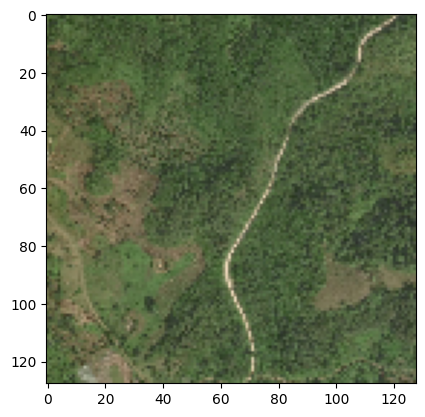

In [29]:
# THIS IS THE ORIGINAL IMAGE 
plt.imshow(train_img[0])

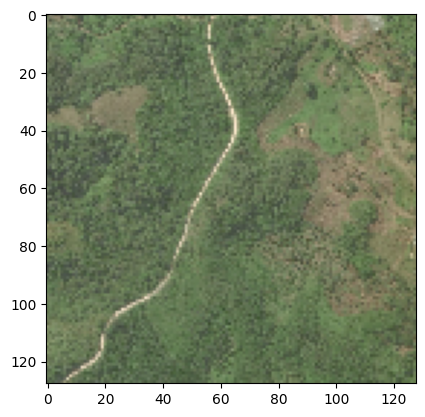

In [30]:
# THIS IS THE IMAGE AFTER GETTING AUGMENTED IT GOT TILTED AND FLIP
plt.imshow(AUG_img['image'])

In [54]:
# TAKING EACH IMAGE AND MASK ONE BY ONE THEN AUGMENTING IT AND APPENDING IT INTO THE LIST 
# IN THIS WAS OUR DATA GETS DOUBLED AND WE WILL GET MORE DATA TO TRAIN
train_imgs,train_masks = train_img.copy(),mask_train.copy()
for image,mask in (zip(train_img,mask_train)):
    aug = get_augmentations()(image=image,mask=mask)
    train_imgs.append(aug['image'])
    train_masks.append(aug['mask'])

In [55]:
len(train_imgs)

12452

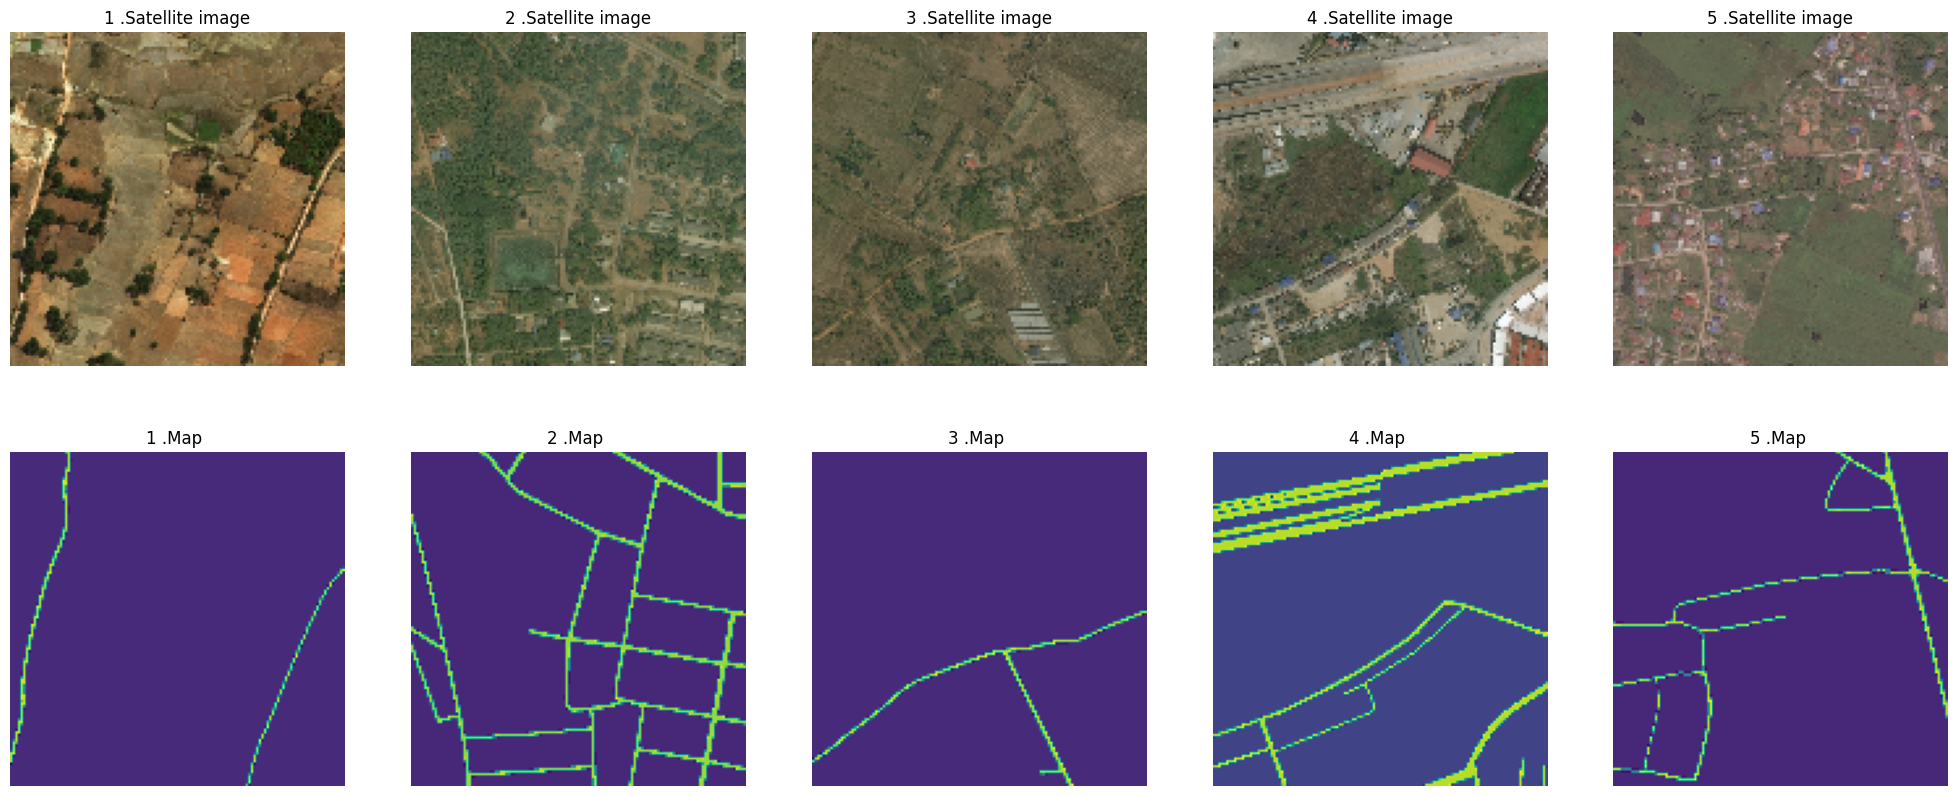

In [56]:
# PLOTTING SOME WITH THEIR RESPICTVES MASK JUST FOR BETTER UNDERSTANDING
plt.figure(figsize=(25,10))
for i in range(1,6):
    image, mask = train_imgs[i+10], train_masks[i+10]
    plt.subplot(2,5,i)
    plt.imshow(image)
    plt.title(str(i) + " .Satellite image")
    plt.axis("off")
    
    plt.subplot(2,5,i + 5)
    plt.imshow(mask)
    plt.title(str(i) + " .Map ")
    plt.axis("off")
plt.show()

In [57]:
# CHANGING THE LIST TO NP ARRAY
train_imgs=np.array(train_imgs)
train_masks=np.array(train_masks)

In [58]:
print(train_imgs.shape)
print(train_masks.shape)

(12452, 128, 128, 3)
(12452, 128, 128)


# **SPLITTING THE DATA INTO TWO TRAINING SETS AND TEST SET**

In [59]:
# HERE I AM SPLITTING THE TRAIN_IMGS AND TRAIN_MASK INTO 3 CATEGORY I HAVE DOME MAINLY THIS BECAUSE 
# WE ARE GETTING RUNNING OUT OF MEMORY WHEN WE TO IT WITHOUT SPLITTING
train_img1=train_imgs[0:6226,:,:,:]
train_mask1=train_masks[0:6226,:,:]
train_img2=train_imgs[6226:11000,:,:,:]
train_mask2=train_masks[6226:11000,:,:]
test_data=train_imgs[11000:12452,:,:,:]
test_masks=train_masks[11000:12452,:,:]

In [60]:
print(train_img1.shape)
print(train_mask1.shape)
print(train_img2.shape)
print(train_mask2.shape)
print(test_data.shape)
print(test_masks.shape)

(6226, 128, 128, 3)
(6226, 128, 128)
(4774, 128, 128, 3)
(4774, 128, 128)
(1452, 128, 128, 3)
(1452, 128, 128)


In [61]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import jaccard_score
from tensorflow.keras import backend as K

In [62]:
# DEVIDING BY 255 FOR SCALING PURPOSE
train_img1 = train_img1 / 255.0
train_img2 = train_img2 / 255.0
test_data = test_data/255.0
# EXPANDING DIMENSIONS SINCE MASKS WERE GRAYSCALE SO THEY DIDN'T HAVE DIMENSION FOR CHANNEL 
# BUT IT IS NESECCARY FOR INPUTING IT IN THE MODEL
train_mask1 = np.expand_dims(train_mask1, axis=-1)
train_mask2 = np.expand_dims(train_mask2, axis=-1)
test_masks=  np.expand_dims(test_masks, axis=-1)



In [63]:
print(train_img1.shape)
print(train_mask1.shape)
print(train_img2.shape)
print(train_mask2.shape)
print(test_data.shape)
print(test_masks.shape)

(6226, 128, 128, 3)
(6226, 128, 128, 1)
(4774, 128, 128, 3)
(4774, 128, 128, 1)
(1452, 128, 128, 3)
(1452, 128, 128, 1)


# MODEL-1(SIMPLE UNET ARCHITECTURE)

**DEFINING LAYERS FOR THE MODELS**

In [19]:
# TRIED WITH ADDING AND REMOVING MANY DROPOUTS LAYERS BUT THIS COMBINATION WAS GIVING 
# THE BEST OUTPUTS
# ALSO ADD L1-L2 REGULARIZATION BUT THEY WERE NOT HELPING IN IMPROVING THE MODEL MUCH SO REMOVED IT
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.metrics import MeanIoU

# Defining Dice coefficient
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

# Defining IoU
def iou(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + 1) / (union + 1)

def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, iou])
    
    return model

model = unet_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

**FITTING THE MODEL**

In [20]:

history1 = model.fit(train_img1, train_mask1, validation_split=0.2, epochs=20, batch_size=32)

history2 = model.fit(train_img2, train_mask2, validation_split=0.1, epochs=20, batch_size=32)



Epoch 1/20


I0000 00:00:1720163438.965442     129 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


156/156 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.9445 - dice_coefficient: 0.0502 - iou: 0.0259 - loss: 0.3779 - val_accuracy: 0.9476 - val_dice_coefficient: 0.0618 - val_iou: 0.0319 - val_loss: 0.1551
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 57s 362ms/step - accuracy: 0.9453 - dice_coefficient: 0.0764 - iou: 0.0398 - loss: 0.1567 - val_accuracy: 0.9476 - val_dice_coefficient: 0.0892 - val_iou: 0.0467 - val_loss: 0.1412
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 57s 363ms/step - accuracy: 0.9450 - dice_coefficient: 0.0986 - iou: 0.0519 - loss: 0.1477 - val_accuracy: 0.9476 - val_dice_coefficient: 0.1073 - val_iou: 0.0567 - val_loss: 0.1372
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 57s 364ms/step - accuracy: 0.9436 - dice_coefficient: 0.1215 - iou: 0.0647 - loss: 0.1451 - val_accuracy: 0.9478 - val_dice_coefficient: 0.1315 - val_iou: 0.0704 - val_loss: 0.1374
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 57s 364ms/step - accuracy: 0.9450 - dice_coefficient: 0.1613 - iou: 0.0879 - loss: 0.1346

**TESTING THE MODEL FOR TEST DATA**

In [21]:
preds = model.predict(test_data)
print(preds.shape)
kert=preds[0]
preds = (preds > 0.5).astype(np.uint8)


preds = tf.cast(preds, tf.float32)


mean_iou = MeanIoU(num_classes=2)
mean_iou.update_state(test_masks, preds)
mean_iou_result = mean_iou.result().numpy()


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


dice_score = dice_coef(tf.cast(test_masks, tf.float32), preds).numpy()

# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_acc}")
print(f"Mean IOU: {mean_iou_result}")
print(f"DICE Score: {dice_score}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 514ms/step
(1452, 128, 128, 1)
Mean IOU: 0.6705469489097595
DICE Score: 0.5485693216323853


**THIS IS THE PREDICTION FOR MASK BY THE MODEL**

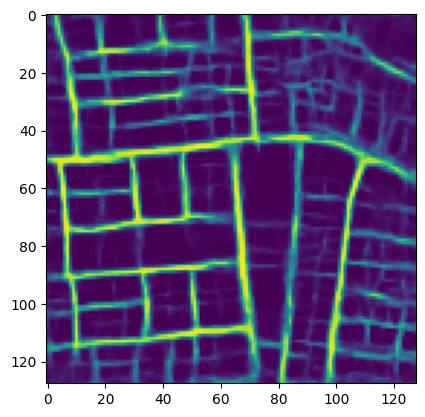

In [22]:
plt.imshow(kert)

**THIS IS THE ACTUAL MASK FOR IT**

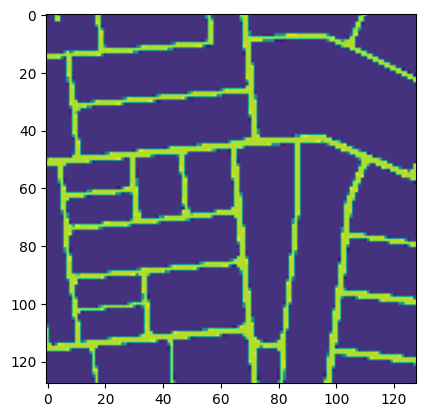

In [23]:
plt.imshow((test_masks[0]))

# MODEL-2(USING UNET ARCH WITH VG19 AS BACKBONE)

**CONCATENATING THE DIFFERENT DATASETS**

I tried training this model with seperate train_img1 and train_img2 seperately but when i tried by doing it after concatenating them it give better result .

In [41]:
train_imgs_conc = np.concatenate((train_img1, train_img2), axis=0)
train_masks_conc = np.concatenate((train_mask1, train_mask2), axis=0)

**DEFINING LAYERS FOR THE MODELS**

Tried with adding dropouts to different layers ,like in the previous model I added more number of dropouts but in this model only adding dropout after 5th convolutional layer give better result .Earlier I trained the model without l1-l2 regularizations but then I added the regularization term and it gives me better results, as compared to those without regularization.

In [40]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.regularizers import l2

def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def unet_vgg19_new(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
#     WE ARE USING THE VG19 BACKBONE FOR ENCODER WITH PRETRAINED WEIGHTS
    vgg19 = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    
    
    conv1 = vgg19.get_layer("block1_conv2").output
    conv2 = vgg19.get_layer("block2_conv2").output
    conv3 = vgg19.get_layer("block3_conv4").output
    conv4 = vgg19.get_layer("block4_conv4").output
    conv5 = vgg19.get_layer("block5_conv4").output
    
    
    conv5 = Dropout(0.5)(conv5)
    
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2), dice_coefficient])
    
    return model

model_vg19 = unet_vgg19_new()
model_vg19.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 32, 32,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv4        │ (None, 16, 16,    │  2,359,808 │ block4_conv3[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv4[0][

 Total params: 30,200,833 (115.21 MB)

 Trainable params: 30,200,833 (115.21 MB)

 Non-trainable params: 0 (0.00 B)

**FITTING THE MODEL**

Earlier i trained the model with seperate train_img1 and train_img2 but then i tried with the concatenated one and give me the better results.

In [42]:
history_new1 = model_vg19.fit(train_imgs_conc, train_masks_conc, epochs=40, batch_size=16, validation_split=0.2)
# history_new2 = model_vg19.fit(train_img2, train_mask2, epochs=30, batch_size=32, validation_split=0.1)


Epoch 1/40


I0000 00:00:1720168811.642432    1286 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


550/550 ━━━━━━━━━━━━━━━━━━━━ 200s 245ms/step - accuracy: 0.9345 - dice_coefficient: 0.0770 - loss: 2.1707 - mean_io_u: 0.4336 - val_accuracy: 0.9445 - val_dice_coefficient: 0.1360 - val_loss: 0.4962 - val_mean_io_u: 0.4639
Epoch 2/40
550/550 ━━━━━━━━━━━━━━━━━━━━ 118s 214ms/step - accuracy: 0.9459 - dice_coefficient: 0.1402 - loss: 0.4589 - mean_io_u: 0.4345 - val_accuracy: 0.9449 - val_dice_coefficient: 0.1507 - val_loss: 0.3804 - val_mean_io_u: 0.4639
Epoch 3/40
550/550 ━━━━━━━━━━━━━━━━━━━━ 117s 213ms/step - accuracy: 0.9448 - dice_coefficient: 0.1601 - loss: 0.3615 - mean_io_u: 0.4334 - val_accuracy: 0.9451 - val_dice_coefficient: 0.1717 - val_loss: 0.3148 - val_mean_io_u: 0.4639
Epoch 4/40
550/550 ━━━━━━━━━━━━━━━━━━━━ 117s 213ms/step - accuracy: 0.9450 - dice_coefficient: 0.1727 - loss: 0.2982 - mean_io_u: 0.4334 - val_accuracy: 0.9450 - val_dice_coefficient: 0.1546 - val_loss: 0.2646 - val_mean_io_u: 0.4639
Epoch 5/40
550/550 ━━━━━━━━━━━━━━━━━━━━ 117s 213ms/step - accuracy: 0.9466 

**TESTING THE MODEL FOR TEST DATA**

In [43]:
preds_vgn = model_vg19.predict(test_data)
print(preds_vgn.shape)
kert_vgn=preds_vgn[0]
preds_vgn = (preds_vgn > 0.5).astype(np.uint8)


preds_vgn = tf.cast(preds_vgn, tf.float32)


mean_iou = MeanIoU(num_classes=2)
mean_iou.update_state(test_masks, preds_vgn)
mean_iou_result = mean_iou.result().numpy()


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


dice_score = dice_coef(tf.cast(test_masks, tf.float32), preds_vgn).numpy()

print(f"Mean IOU: {mean_iou_result}")
print(f"DICE Score: {dice_score}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 482ms/step
(1452, 128, 128, 1)
Mean IOU: 0.6620115637779236
DICE Score: 0.5459345579147339


**THIS IS THE MASK PREDICTED BY THE MODEL**

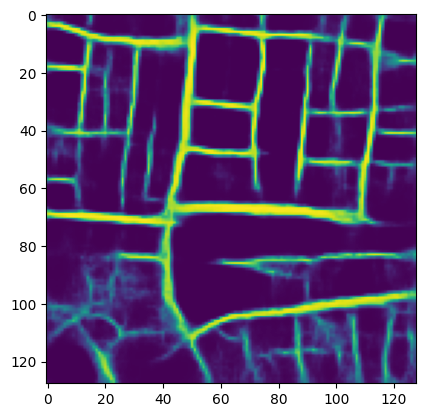

In [44]:
plt.imshow(kert_vgn)

**THIS IS THE ACTUAL MASK FOR IT**

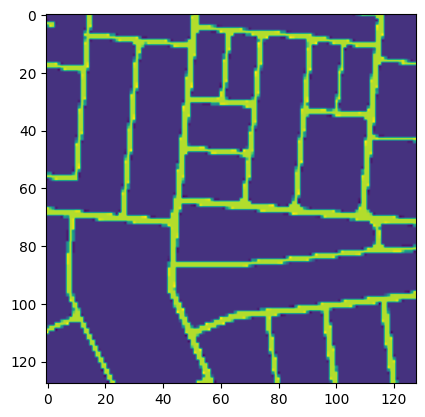

In [45]:
plt.imshow((test_masks[0]))

# MODEL-3(USING UNET ARCH WITH VG16 AS BACKBONE)

**DEFINING LAYERS FOR THE MODELS**

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def unet_vgg16(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    # VGG16 encoder
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    
    # Encoder layers
    conv1 = vgg16.get_layer("block1_conv2").output
#     conv1 = Dropout(0.5)(conv1)
    conv2 = vgg16.get_layer("block2_conv2").output
#     conv2 = Dropout(0.5)(conv2)
    conv3 = vgg16.get_layer("block3_conv3").output
#     conv3 = Dropout(0.5)(conv3)
    conv4 = vgg16.get_layer("block4_conv3").output
    conv5 = vgg16.get_layer("block5_conv3").output
    
    
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(conv9)
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model

model_vg16 = unet_vgg16()
model_vg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2), dice_coefficient, iou_coefficient])
model_vg16.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 8, 8, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 24,892,229 (94.96 MB)

 Trainable params: 24,892,229 (94.96 MB)

 Non-trainable params: 0 (0.00 B)

**FITTING THE MODEL**

In [47]:
history_newvg16 = model_vg16.fit(train_imgs_conc, train_masks_conc, epochs=40, batch_size=16, validation_split=0.1)

Epoch 1/40
619/619 ━━━━━━━━━━━━━━━━━━━━ 178s 263ms/step - accuracy: 0.9447 - dice_coefficient: 0.0794 - iou_coefficient: 0.0415 - loss: 0.7228 - mean_io_u_2: 0.4274 - val_accuracy: 0.9411 - val_dice_coefficient: 0.1278 - val_iou_coefficient: 0.0684 - val_loss: 0.1655 - val_mean_io_u_2: 0.4801
Epoch 2/40
619/619 ━━━━━━━━━━━━━━━━━━━━ 121s 195ms/step - accuracy: 0.9451 - dice_coefficient: 0.1613 - iou_coefficient: 0.0880 - loss: 0.1463 - mean_io_u_2: 0.4276 - val_accuracy: 0.9411 - val_dice_coefficient: 0.1786 - val_iou_coefficient: 0.0983 - val_loss: 0.1496 - val_mean_io_u_2: 0.4801
Epoch 3/40
619/619 ━━━━━━━━━━━━━━━━━━━━ 120s 193ms/step - accuracy: 0.9447 - dice_coefficient: 0.2001 - iou_coefficient: 0.1114 - loss: 0.1313 - mean_io_u_2: 0.4273 - val_accuracy: 0.9411 - val_dice_coefficient: 0.2030 - val_iou_coefficient: 0.1132 - val_loss: 0.1354 - val_mean_io_u_2: 0.4801
Epoch 4/40
619/619 ━━━━━━━━━━━━━━━━━━━━ 119s 192ms/step - accuracy: 0.9457 - dice_coefficient: 0.2196 - iou_coefficien

In [48]:
preds_vgn16 = model_vg16.predict(test_data)
print(preds_vgn16.shape)
kert_vgn16=preds_vgn16[0]
preds_vgn16 = (preds_vgn16 > 0.5).astype(np.uint8)


preds_vgn16 = tf.cast(preds_vgn16, tf.float32)


mean_iou = MeanIoU(num_classes=2)
mean_iou.update_state(test_masks, preds_vgn16)
mean_iou_result = mean_iou.result().numpy()


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


dice_score = dice_coef(tf.cast(test_masks, tf.float32), preds_vgn16).numpy()


print(f"Mean IOU: {mean_iou_result}")
print(f"DICE Score: {dice_score}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step
(1452, 128, 128, 1)
Mean IOU: 0.6432174444198608
DICE Score: 0.4865351915359497


# MODEL-4(USING PYTORCH SEGMENTATION MODEL-VG16)

**Installing pytorch segmentation models,important  library configuring cuda**

In [49]:
!pip install segmentation-models-pytorch

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.7 MB/s eta 0:00:00:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5aa62b955f73e5d29597be7d68a75b838915eb16d5b4f8d004d945fc532af5dd
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=111d524ee63009ed3b4dd463cbd193c82f76bbea21fdbba417679be819f1210c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [50]:
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import segmentation_models_pytorch as smp
from sklearn.metrics import jaccard_score, f1_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**DOING MODIFICATION IN TRAIN AND TEST DATA TO MAKE IT COMPATIBLE FOR THE MODEL**

In [64]:

train_img1 = train_img1.transpose((0, 3, 1, 2))
train_img2 = train_img2.transpose((0, 3, 1, 2))
test_data = test_data.transpose((0, 3, 1, 2))
train_mask1 = train_mask1.transpose((0, 3, 1, 2))
train_mask2 = train_mask2.transpose((0, 3, 1, 2))
test_masks = test_masks.transpose((0, 3, 1, 2))

# Convert data to PyTorch tensors
train_img1 = torch.tensor(train_img1, dtype=torch.float32)
train_img2 = torch.tensor(train_img2, dtype=torch.float32)
train_mask1 = torch.tensor(train_mask1, dtype=torch.float32)
train_mask2 = torch.tensor(train_mask2, dtype=torch.float32)
test_img = torch.tensor(test_data, dtype=torch.float32)
test_mask = torch.tensor(test_masks, dtype=torch.float32)


train_dataset1 = TensorDataset(train_img1, train_mask1)
train_loader1 = DataLoader(train_dataset1, batch_size=16, shuffle=True)

train_dataset2 = TensorDataset(train_img2, train_mask2)
train_loader2 = DataLoader(train_dataset2, batch_size=16, shuffle=True)

test_dataset = TensorDataset(test_img, test_mask)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [65]:
print(train_img1.shape)
print(train_mask1.shape)
print(train_img2.shape)
print(train_mask2.shape)
print(test_img.shape)
print(test_mask.shape)

torch.Size([6226, 3, 128, 128])
torch.Size([6226, 1, 128, 128])
torch.Size([4774, 3, 128, 128])
torch.Size([4774, 1, 128, 128])
torch.Size([1452, 3, 128, 128])
torch.Size([1452, 1, 128, 128])


**DEFINING MODEL**

In [66]:
model = smp.Unet(encoder_name="vgg16", encoder_weights="imagenet", in_channels=3, classes=1)
model = model.to(device)

# I TRIED WITH LEARNING RATE 0.001 EARLIER BUT THIS MADE THE MODEL SLIGHTLY UNSTABLE LIKE LOSS WERE DECREASING
# AND SOMETIMES INCREASING WITH ITERATIONS TOO THEN IC HANGED IT TO 0.0005 
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = smp.losses.DiceLoss(mode='binary')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 307MB/s]  


**TRAINING THE MODEL**

In [67]:
def train_model(loader, model, optimizer, loss_func, device):
    model.train()
    epoch_loss = 0
    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_func(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)


num_epochs = 40
for epoch in range(num_epochs):
    loss1 = train_model(train_loader1, model, optimizer, loss_func, device)
    loss2 = train_model(train_loader2, model, optimizer, loss_func, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss1: {loss1:.4f}, Loss2: {loss2:.4f}")


Epoch 1/40, Loss1: 0.6178, Loss2: 0.5195
Epoch 2/40, Loss1: 0.4574, Loss2: 0.4653
Epoch 3/40, Loss1: 0.4206, Loss2: 0.4411
Epoch 4/40, Loss1: 0.3967, Loss2: 0.4188
Epoch 5/40, Loss1: 0.3767, Loss2: 0.3975
Epoch 6/40, Loss1: 0.3642, Loss2: 0.3845
Epoch 7/40, Loss1: 0.3475, Loss2: 0.3736
Epoch 8/40, Loss1: 0.3364, Loss2: 0.3577
Epoch 9/40, Loss1: 0.3230, Loss2: 0.3491
Epoch 10/40, Loss1: 0.3120, Loss2: 0.3380
Epoch 11/40, Loss1: 0.3040, Loss2: 0.3289
Epoch 12/40, Loss1: 0.2948, Loss2: 0.3173
Epoch 13/40, Loss1: 0.2879, Loss2: 0.3105
Epoch 14/40, Loss1: 0.2792, Loss2: 0.3011
Epoch 15/40, Loss1: 0.2725, Loss2: 0.3005
Epoch 16/40, Loss1: 0.2670, Loss2: 0.2899
Epoch 17/40, Loss1: 0.2614, Loss2: 0.2845
Epoch 18/40, Loss1: 0.2559, Loss2: 0.2785
Epoch 19/40, Loss1: 0.2508, Loss2: 0.2790
Epoch 20/40, Loss1: 0.2459, Loss2: 0.2691
Epoch 21/40, Loss1: 0.2427, Loss2: 0.2643
Epoch 22/40, Loss1: 0.2379, Loss2: 0.2607
Epoch 23/40, Loss1: 0.2358, Loss2: 0.2555
Epoch 24/40, Loss1: 0.2309, Loss2: 0.2530
E

**TESTING THE MODEL**

In [68]:
def evaluate_model(loader, model, device):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs = model(imgs)
            preds.append(outputs.cpu().numpy())
            trues.append(masks.cpu().numpy())
    
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    
    preds = (preds > 0.5).astype(np.uint8)
    trues = trues.astype(np.uint8)
    
    iou = jaccard_score(trues.flatten(), preds.flatten())
    dice = f1_score(trues.flatten(), preds.flatten())
    
    return iou, dice


iou, dice = evaluate_model(test_loader, model, device)
print(f"Mean IOU: {iou:.4f}, DICE Score: {dice:.4f}")


Mean IOU: 0.4569, DICE Score: 0.6272


**COMPARING THE ACTUAL MASK AND PREDICTED MASK**

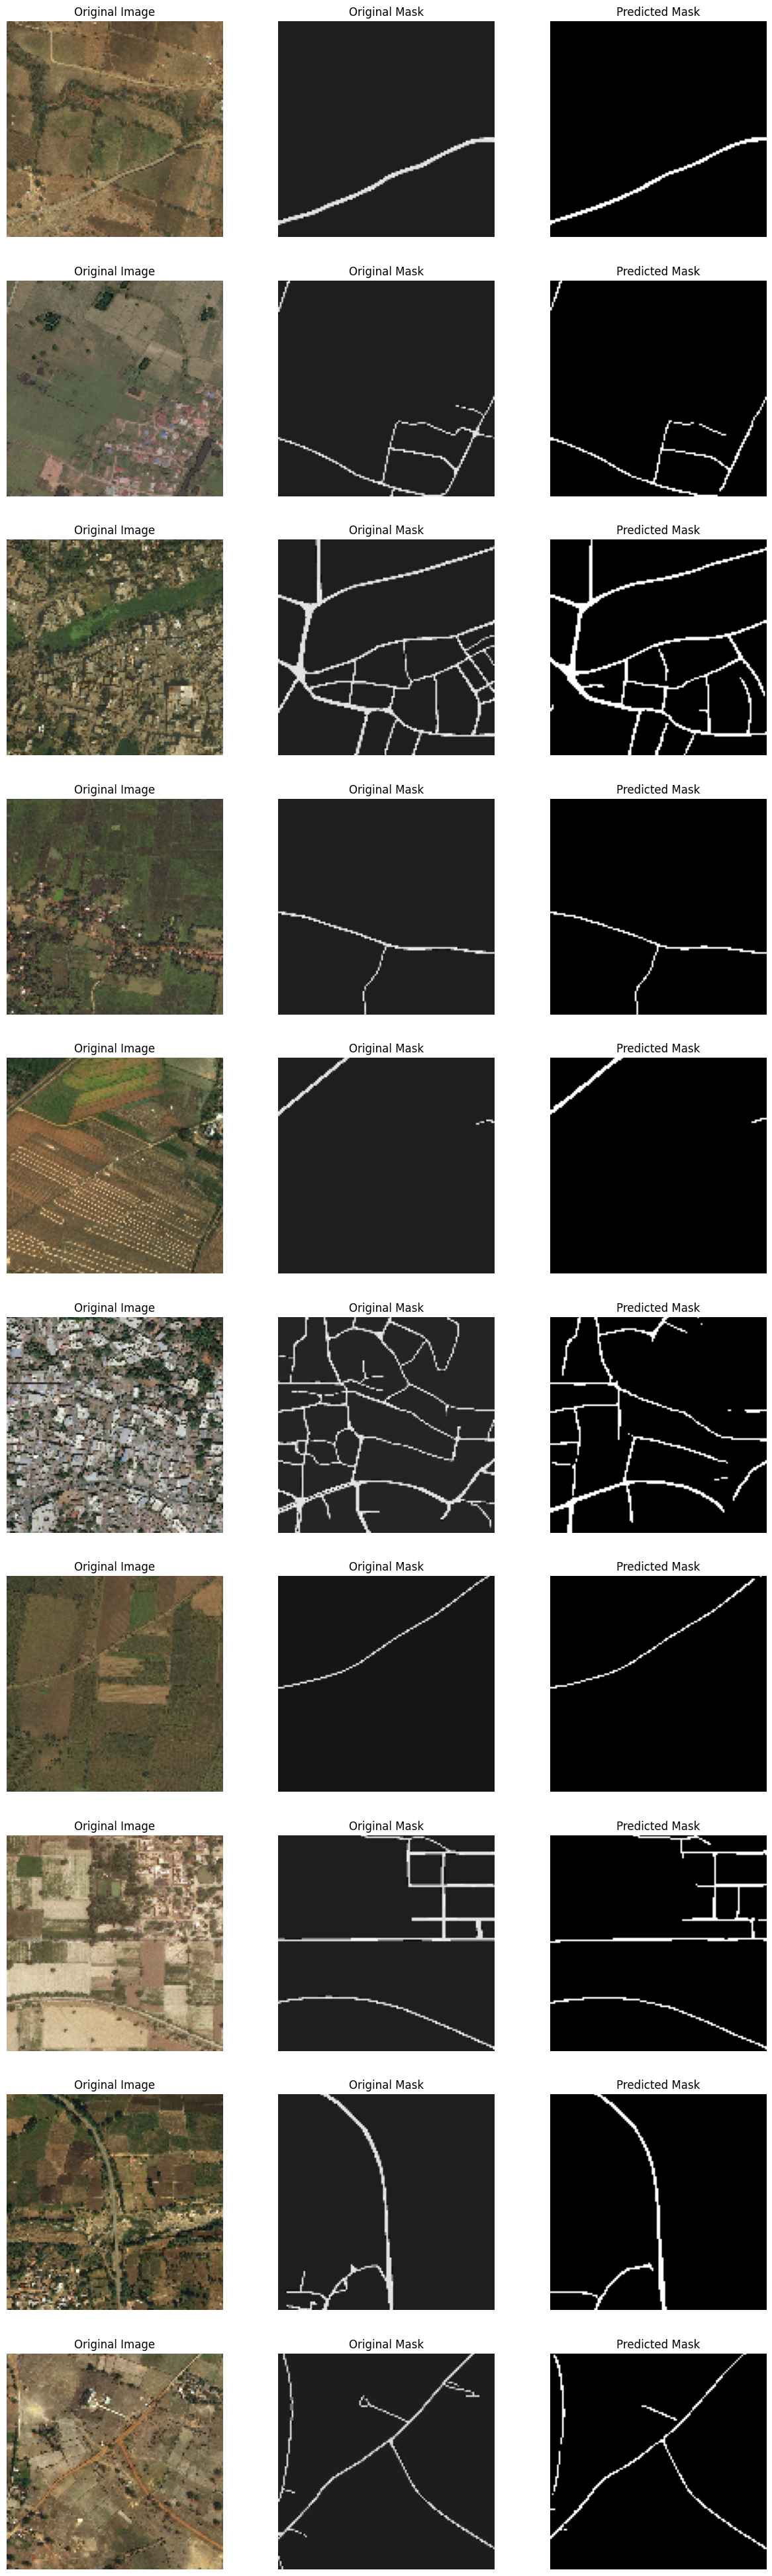

In [75]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch


def visualize_predictions(model, images, masks, device, num_samples=10):
    indices = random.sample(range(len(images)), num_samples)
    model.eval()

    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            single_image = images[idx].unsqueeze(0).float().to(device)  
            single_mask = masks[idx].unsqueeze(0).float().to(device)  

            predicted_mask = model(single_image)
            predicted_mask = predicted_mask.squeeze(0).squeeze(0).cpu().numpy() 
            predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

            original_image = single_image.squeeze(0).cpu().numpy().transpose((1, 2, 0))  
            original_mask = single_mask.squeeze(0).squeeze(0).cpu().numpy()  

            axs[i, 0].imshow(original_image)
            axs[i, 0].set_title('Original Image')
            axs[i, 0].axis('off')

            axs[i, 1].imshow(original_mask, cmap='gray')
            axs[i, 1].set_title('Original Mask')
            axs[i, 1].axis('off')

            axs[i, 2].imshow(predicted_mask, cmap='gray')
            axs[i, 2].set_title('Predicted Mask')
            axs[i, 2].axis('off')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

visualize_predictions(model, train_img1, train_mask1, device)


# PREDICTING MASK FOR IIT BHU GOOGLE EARTH VIEW

In [76]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


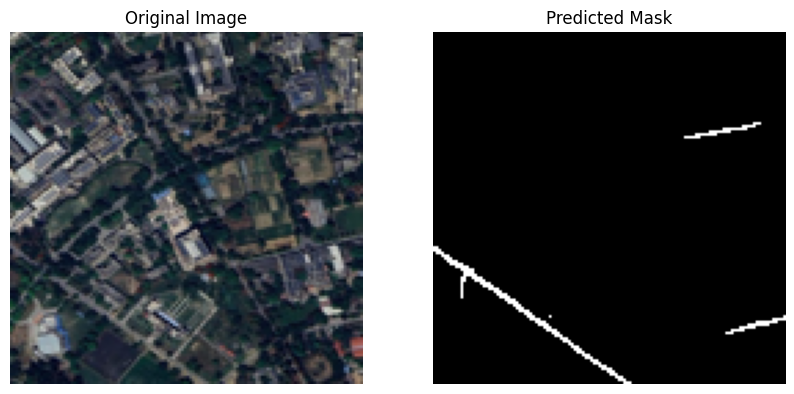

In [77]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    if transform is not None:
        image = transform(image)
    return image

def predict_mask(image_path, model, device):
    
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
    
    
    image = load_image(image_path, transform)
    image = image.unsqueeze(0)  
    
    
    image = image.float().to(device)
    
    
    model.eval()
    with torch.no_grad():
        predicted_mask = model(image)
    
    
    predicted_mask = predicted_mask.squeeze(0).squeeze(0).cpu().numpy()  
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    
    return image, predicted_mask

def visualize_prediction(image_path, predicted_mask):
    
    original_image = Image.open(image_path).convert('RGB')
    original_image = original_image.resize((128, 128))
    
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(predicted_mask, cmap='gray')
    axs[1].set_title('Predicted Mask')
    axs[1].axis('off')
    
    plt.show()


image_path = '/kaggle/input/iit-bhu-earth/WhatsApp Image 2024-07-05 at 18.14.14.jpeg' 


image, predicted_mask = predict_mask(image_path, model, device)
visualize_prediction(image_path, predicted_mask)


I THINK THE MODEL IS NOT ABLE TO DETECT SOME PARTS OF THE ROAD BECAUSE OF THE TRESS COVERING THE ROAD AND VERY LITTLE PART OF ROAD BEING VISIBLE

# **COMPARING THE PERFORMANCES OF DIFFERENT MODELS**


**ACTUALLY MODEL-3 THE  VG_16 MODEL WHICH IS DEFINED LAYER BY LAYER WAS GIVING BETTER RESULTS WHEN TRAINED ON TRAIN_IMG1 AND TRAIN_IMG2 SEPERATELY AS COMPARED TO CONCATENATED DATASETS BUT IN THE NOTEBOOK I TRAINED IT ON THE PREVIOUS ONE AND SINCE RUNNING EPOCH AGAIN WILL TAKE TIME SO I AM SUBMITTING IT WITH THAT ONLY**

**ON THE BASIS OF DICE SCORE AND IOU THE VG_16 MODEL(MODEL-4) BUILT USING PYTORCH SEGMENTATION MODEL HAS PERFORMED THE BEST THEN (MODEL-3) VG_16 LAYER BY LAYER THEN VG_19 AND SIMPLE U_NET**